In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import json
import time

import keras
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import Flatten, Concatenate, Lambda
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

import hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp, space_eval

In [2]:
# Change the work directory 
print('Current work directory: ' + str(os.getcwd()))
print('Changing the work directory...')
os.chdir('../')
print('New work directory: ' + str(os.getcwd()))

Current work directory: /home/jovyan/work/DECODER/decoder-variable-misuse/notebooks
Changing the work directory...
New work directory: /home/jovyan/work/DECODER/decoder-variable-misuse


In [3]:
# Import our own modules/functions
from src.pointer_networks.PointerLSTM_decoder import PointerLSTM
from src.visualization.visualize import plot_model_results, plot_confusion_matrix
from src.features.performance_metrics import cardinal, model_evaluation

In [4]:
# Load training, validation and test sets
X_tr = np.load('data/processed/C_Cpp/X_tr_200t.npy')
y_tr = np.load('data/processed/C_Cpp/y_tr_200t.npy')
X_val = np.load('data/processed/C_Cpp/X_val_200t.npy')
y_val = np.load('data/processed/C_Cpp/y_val_200t.npy')
X_test = np.load('data/processed/C_Cpp/X_test_200t.npy')
y_test = np.load('data/processed/C_Cpp/y_test_200t.npy')

In [5]:
# Check set sizes
print('Shape of training inputs: ', X_tr.shape)
print('Shape of training labels: ', y_tr.shape)
print('Shape of validation inputs: ', X_val.shape)
print('Shape of validation labels: ', y_val.shape)
print('Shape of test inputs: ', X_test.shape)
print('Shape of test labels: ', y_test.shape)

Shape of training inputs:  (52498, 200)
Shape of training labels:  (52498, 2, 200)
Shape of validation inputs:  (2917, 200)
Shape of validation labels:  (2917, 2, 200)
Shape of test inputs:  (2917, 200)
Shape of test labels:  (2917, 2, 200)


In [6]:
# Load dictionary to set the dimension of the embedding
with open('data/processed/OpenCV/token2idx_c_cpp_200tokens.json') as fp:
    token2idx = json.load(fp)

In [7]:
# Space for hyperparameter values to try in the optimization
space = {
    'seq_len': 200,
    'input_dim': len(token2idx),
    'batch_size': hp.quniform('batch size', 24, 80, 2),
    #'batch_size': hp.choice('batch size', [16, 32, 64]),
    'hidden_size': hp.quniform('hidden_size', 90, 300, 5),
    #'hidden_size': hp.choice('hidden_size', [30, 50, 80, 120]),
    'dropout': hp.uniform('dropout', 0.1 , 0.25),
    'lstm_dropouts': hp.uniform('lstm_dropouts', 0.1, 0.25),
    'optimizer' : hp.choice('optimizer', ['adam','rmsprop']),
    'nb_epochs' : 100,
    'lr': hp.uniform('lr', 0.001, 0.01)
}

In [8]:
# Function to optimize models
def optimize(space, trials, max_evals, df_to_save):
    # Define objective function
    def objective(params, trials=trials, df_to_save=df_to_save):
        params['hidden_size'] = int(params['hidden_size'])  # For using quniform - it does not output an integer
        params['batch_size'] = int(params['batch_size'])  # For using quniform - it does not output an integer

        print("\nTraining with params: ")
        print(params)

        # Building model
        main_input = Input(shape=(params['seq_len'], ), name='main_input')
        emb = Embedding(input_dim=params['input_dim'], output_dim=params['seq_len'], input_length=params['seq_len'], name='embedding')(main_input)
        encoder, state_h, state_c = LSTM(units=params['hidden_size'], recurrent_dropout=params['lstm_dropouts'], dropout=params['dropout'],
                                         return_sequences=True, name="encoder", return_state=True)(emb)
        decoder = PointerLSTM(params['hidden_size'])(encoder, states=[state_h, state_c])
        model = Model(main_input, decoder)
        print("\nModel architecture:")
        print(model.summary())

        # Compilation
        if params['optimizer'] == 'rmsprop':
            opt = RMSprop(learning_rate=params['lr'])

        if params['optimizer'] == 'adam':
            opt = Adam(learning_rate=params['lr'])

        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        # Attach epochs and learning rate for using in callbacks
        nb_epochs = params['nb_epochs']
        learning_rate = params['lr']

        # Callbacks
        def scheduler(epoch):
            if epoch < nb_epochs/4:
                return learning_rate
            elif epoch < nb_epochs/2:
                return learning_rate*0.5
            return learning_rate*0.1

        model_path ='src/pointer_networks/models/ptrNet_{epoch:02d}_{val_loss:.4f}_c.hdf5'
        checkpointer = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
        reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
        #lr_schedule = LearningRateScheduler(scheduler, verbose=1)
        group_callbacks = [checkpointer, earlystopper, reducer]#, lr_schedule]

        # Train model
        np.random.seed(1)   # To get reproducible results
        history = model.fit(X_tr, y_tr, epochs=params['nb_epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val), verbose=2, 
                            callbacks=group_callbacks)

        # Plot the resuls
        hist = pd.DataFrame(history.history)

        plt.style.use('ggplot')
        plt.figure(figsize=(12,12))
        plt.plot(np.arange(len(hist))+1, hist['accuracy'], marker='o', label='Training')
        plt.plot(np.arange(len(hist))+1, hist['val_accuracy'], marker='o', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.show()

        # Predict the test set 
        score, acc = model.evaluate(X_test, y_test, verbose=2)
        print('Test accuracy:', acc)
        print(' ') 

        # Save info into df - update it in each iteration. Add accuracy.
        params_to_save = params.copy()
        params_to_save.update({'accuracy': -acc})
        
        try:
            df_to_save = pd.read_csv('data/processed/OpenCV/hyperparams_results_C4.csv')
        
        except:
            pass

        df_to_save = pd.concat([df_to_save, pd.DataFrame(params_to_save, index=[0])], ignore_index=True)
        df_to_save.to_csv('data/processed/OpenCV/hyperparams_results_C4.csv', index=False)

        return {'loss': -acc, 'status': STATUS_OK, 'model': model} # if accuracy use '-' sign
    
    # Function to minimize the objective
    best = fmin(fn=objective, space=space, algo=tpe.rand.suggest, max_evals=max_evals, trials=trials)
    best = space_eval(space, best)
    
    return best

In [ ]:
# Search best hyperparameter values
trials = Trials()
max_evals = 63

start = time.time()
hyperparams_result = pd.DataFrame()
best = optimize(space, trials, max_evals, df_to_save=hyperparams_result)
print('\n===============================================')
print("\nBest hyperparameters: ", "\n")
print(best)
end = time.time()
print('\nTime elapsed to optimize {0} executions: {1}'.format(max_evals, end - start))


Training with params: 
{'batch_size': 66, 'dropout': 0.1109398009049295, 'hidden_size': 160, 'input_dim': 8805, 'lr': 0.001937149718917708, 'lstm_dropouts': 0.23239188512188733, 'nb_epochs': 100, 'optimizer': 'adam', 'seq_len': 200}

Model architecture:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          1761000   
_________________________________________________________________
encoder (LSTM)               [(None, 200, 160), (None, 231040    
_________________________________________________________________
pointer (PointerLSTM)        (None, 2, None)           256800    
Total params: 2,248,840
Trainable params: 2,248,840
Non-trainable params: 0
____________________________________________________________

In [22]:
# DataFrame with all hyperparameter values tried and their associated test accuracy
hyperparams_results = pd.DataFrame()

for t in trials:
    dic_inter = t['misc']['vals'].copy()
    dic_inter.update({'accuracy': [-t['result']['loss']]})
    
    hyperparams_results = pd.concat([hyperparams_results, pd.DataFrame(dic_inter)], ignore_index=True)
    
# Change index to actually value for those params specified with hp.choice
#batch_size_list = [16, 32, 64]
#hidden_size_list = [280, 300, 350, 380]
optimizer_list = ['adam','rmsprop']

#hyperparams_results['batch size'] = hyperparams_results['batch size'].apply(lambda x: batch_size_list[x])
#hyperparams_results['hidden_size'] = hyperparams_results['hidden_size'].apply(lambda x: hidden_size_list[x])
hyperparams_results['optimizer'] = hyperparams_results['optimizer'].apply(lambda x: optimizer_list[x])
hyperparams_results['batch size'] = hyperparams_results['batch size'].apply(lambda x: int(x))   # If it is quniform
hyperparams_results['hidden_size'] = hyperparams_results['hidden_size'].apply(lambda x: int(x))  # If it is quniform
 
hyperparams_results
hyperparams_results.to_csv('data/processed/OpenCV//hyperparams_results_C4.csv', index=False)

In [23]:
hyperparams_results

,batch size,dropout,hidden_size,lr,lstm_dropouts,optimizer,accuracy
0,66,0.110940,160,0.001937,0.232392,adam,0.480459
1,74,0.201528,215,0.004638,0.112924,adam,0.487830
2,28,0.192596,280,0.009567,0.193604,adam,0.352760
3,64,0.145677,275,0.008945,0.113816,adam,0.430408
4,66,0.166707,280,0.005759,0.209249,adam,0.448920
5,76,0.147504,110,0.009125,0.237426,rmsprop,0.431436
6,72,0.200068,290,0.002271,0.122740,rmsprop,0.536167
7,58,0.129271,190,0.007112,0.209152,adam,0.422352
8,54,0.235703,220,0.007665,0.210809,adam,0.424923
9,34,0.220098,110,0.006071,0.105717,adam,0.435550


In [ ]:
# Function to get the best model after optimizing (already training)
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    
    return best_trial_obj['result']['model']

In [ ]:
# Get the best trained model and use it to get evaluate the model
best_model = getBestModelfromTrials(trials)

pred_tr = best_model.predict(X_tr)
pred_val = best_model.predict(X_val)
pred_test = best_model.predict(X_test)
y_tr_cardinal = cardinal(y_tr, pred_tr)
y_val_cardinal = cardinal(y_val, pred_val)
y_test_cardinal = cardinal(y_test, pred_test)
pred_tr_cardinal = np.argmax(pred_tr, axis=-1)
pred_val_cardinal = np.argmax(pred_val, axis=-1)
pred_test_cardinal = np.argmax(pred_test, axis=-1)

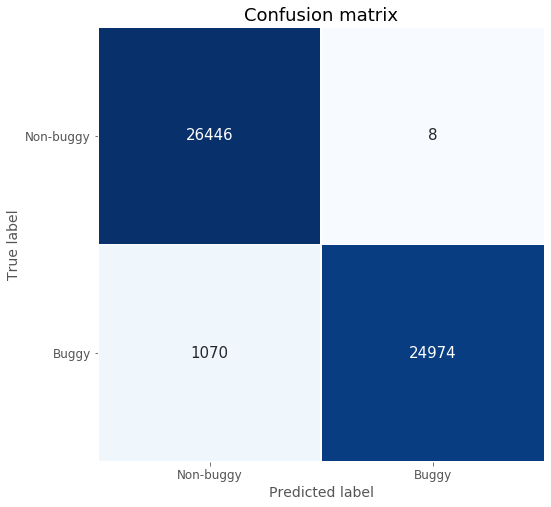

In [24]:
# Confusion matrix for training set
plot_confusion_matrix(y_tr_cardinal, pred_tr_cardinal)

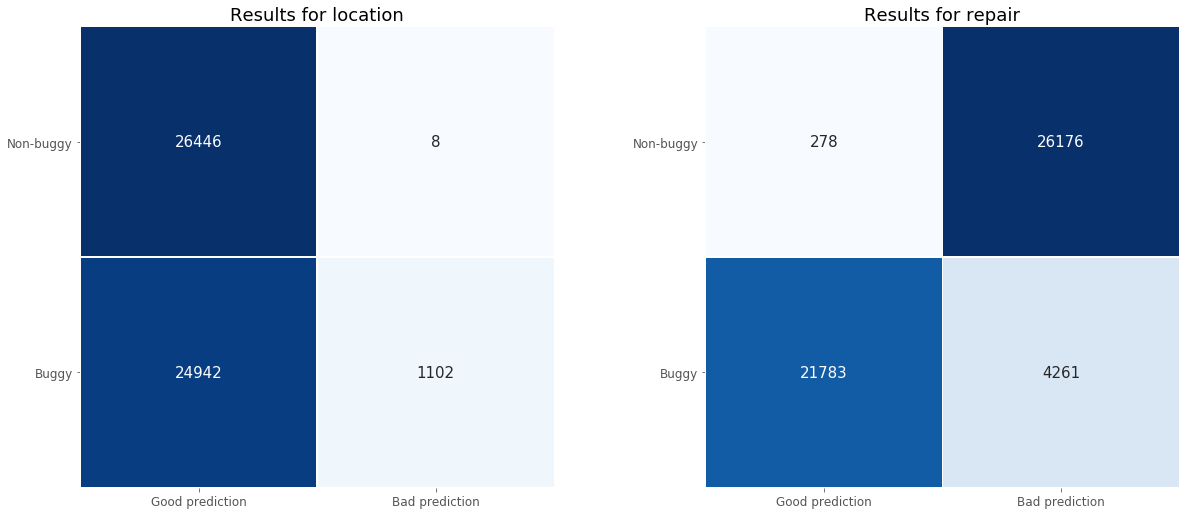

In [25]:
# Results for training set
plot_model_results(y_tr_cardinal, pred_tr_cardinal)

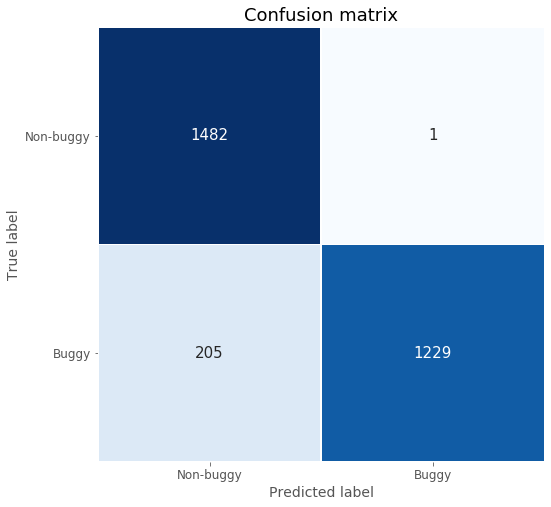

In [26]:
# Confusion matrix for validation set
plot_confusion_matrix(y_val_cardinal, pred_val_cardinal)

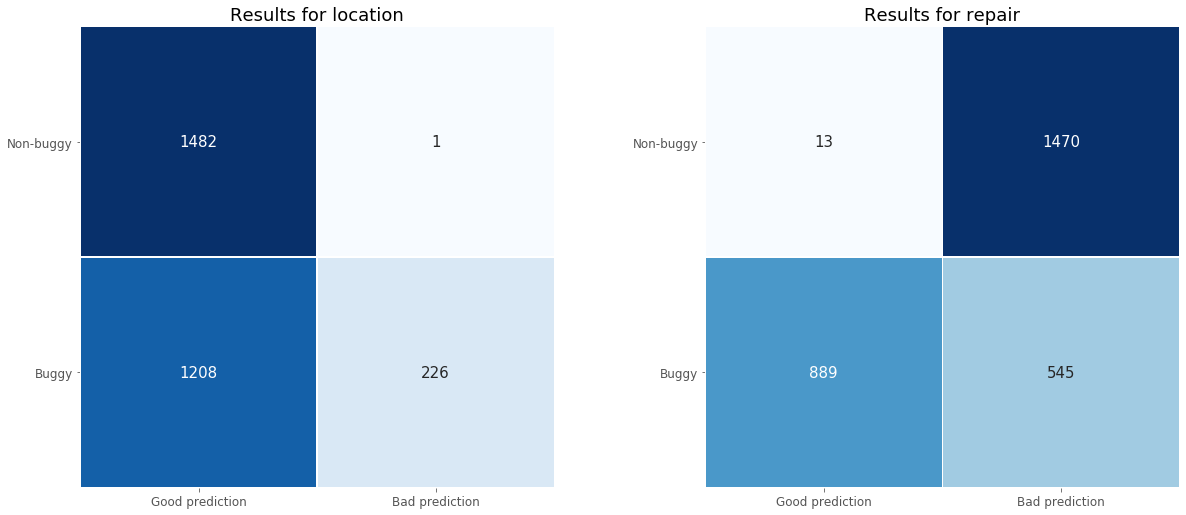

In [27]:
# Results for validation set
plot_model_results(y_val_cardinal, pred_val_cardinal)

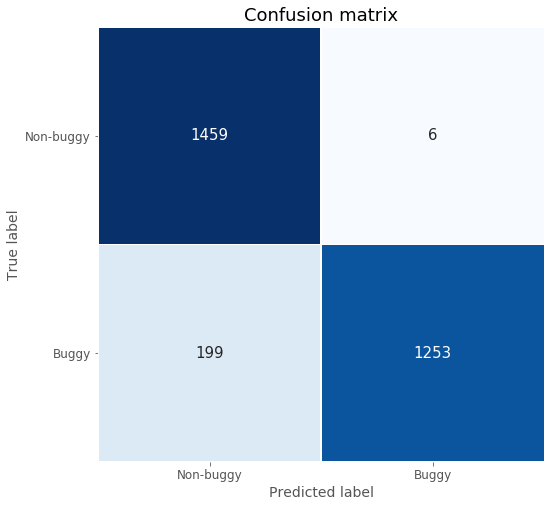

In [28]:
# Confusion matrix for test set
plot_confusion_matrix(y_test_cardinal, pred_test_cardinal)

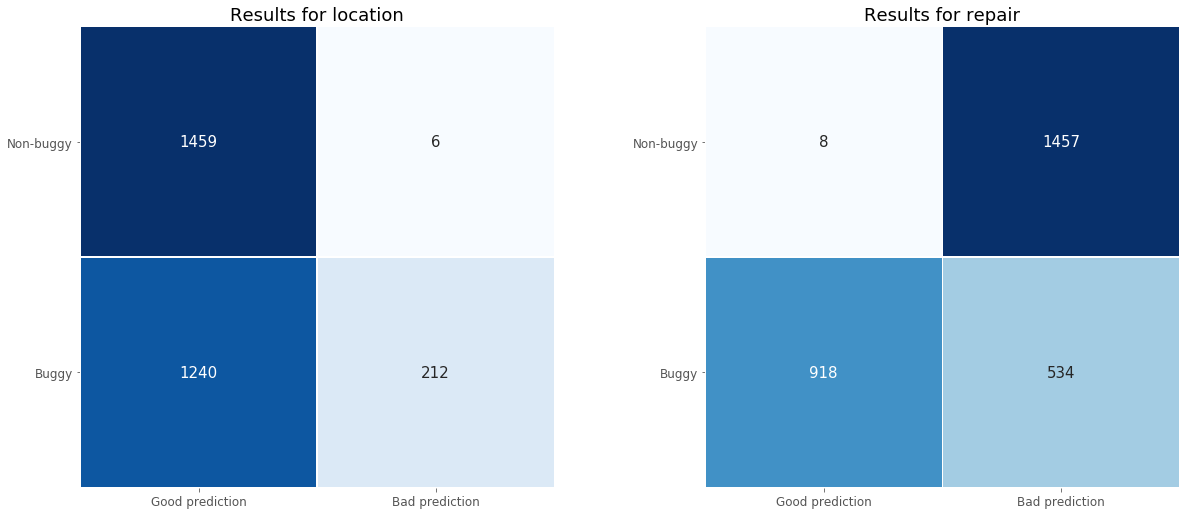

In [29]:
# Results for test set
plot_model_results(y_test_cardinal, pred_test_cardinal)

In [30]:
# Calculate the metrics used in the paper to compare different model's performance
tr_metrics = model_evaluation(y_tr_cardinal, pred_tr_cardinal)
val_metrics = model_evaluation(y_val_cardinal, pred_val_cardinal)
test_metrics = model_evaluation(y_test_cardinal, pred_test_cardinal)

In [ ]:
all_metrics = [tr_metrics, val_metrics, test_metrics]
size_set = [X_tr.shape[0], X_val.shape[0], X_test.shape[0]]
set_names = ['Training', 'Validation', 'Test']

result_metrics = pd.DataFrame()

for metric, name, size in zip(all_metrics, set_names, size_set):
    # Show results
    print('\n=====================================')
    print('Evaluation metrics for ' + name + ' set')
    print('Size:', size)
    print('=====================================')
    print('True Positive:', metric[0])
    print('Class Accuracy:', metric[1])
    print('Localization Accuracy:', metric[2])
    print('Localization+Repair Accuracy:', metric[3])
    
    # For saving results info in a CSV
    df_inter = pd.DataFrame({'set':[name], 'size':[size], 'true_positive':metric[0], 'class_accuracy':metric[1], 'loc_accuracy':metric[2], 
                             'loc_rep_accuracy':metric[3]})
    
    result_metrics = pd.concat([result_metrics, df_inter], ignore_index=True)
    
result_metrics.to_csv('data/processed/OpenCV/metrics_c_bestModel4.csv', index=False)

In [31]:
result_metrics

,set,size,true_positive,class_accuracy,loc_accuracy,loc_rep_accuracy
0,Training,52498,0.99970,0.97947,0.95769,0.82426
1,Validation,2917,0.99933,0.92938,0.84240,0.59135
2,Test,2917,0.99590,0.92972,0.85399,0.60331


In [ ]:
# Save model
best_model.save('models/c_cpp_best_model.h5')